## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from pathlib import Path

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Cleaned Data

In [2]:
# Define paths
DATA_PATH = Path('../data/processed/cleaned_tweets.csv')
MODELS_PATH = Path('../models/ml')
VECTORIZER_PATH = Path('../models/vectorizers')
VISUALS_PATH = Path('../visuals/confusion_matrices')

# Create directories if they don't exist
MODELS_PATH.mkdir(parents=True, exist_ok=True)
VECTORIZER_PATH.mkdir(parents=True, exist_ok=True)
VISUALS_PATH.mkdir(parents=True, exist_ok=True)

# Load the cleaned dataset
df = pd.read_csv(DATA_PATH)

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

df.head()

Dataset loaded: (99735, 4)

Columns: ['text', 'text_clean', 'sentiment', 'sentiment_label']

Sentiment distribution:
sentiment
0    49893
1    49842
Name: count, dtype: int64


,text,text_clean,sentiment,sentiment_label
0,@xnausikaax oh no! where did u order from? tha...,oh no where did u order from that s horrible,0,negative
1,A great hard training weekend is over. a coup...,a great hard training weekend is over a couple...,0,negative
2,"Right, off to work Only 5 hours to go until I...",right off to work only hours to go until i m f...,0,negative
3,I am craving for japanese food,i am craving for japanese food,0,negative
4,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work ...,0,negative


## 3. Prepare Features and Labels

In [3]:
# Extract features (cleaned text) and labels (sentiment)
X = df['text_clean']  # Cleaned text
y = df['sentiment']   # 0 = negative, 1 = positive

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts())

Features shape: (99735,)
Labels shape: (99735,)

Label distribution:
sentiment
0    49893
1    49842
Name: count, dtype: int64


## 4. Split Data: Train/Test

In [4]:
# Split data into training (80%) and testing (20%)
# stratify=y ensures both sets have the same proportion of positive/negative sentiments
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class balance
)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"\nTraining set sentiment distribution:")
print(y_train.value_counts())
print(f"\nTesting set sentiment distribution:")
print(y_test.value_counts())

Training set size: 79788 samples
Testing set size: 19947 samples

Training set sentiment distribution:
sentiment
0    39914
1    39874
Name: count, dtype: int64

Testing set sentiment distribution:
sentiment
0    9979
1    9968
Name: count, dtype: int64


## 5. TF-IDF Vectorization

**TF-IDF** (Term Frequency-Inverse Document Frequency) converts text into numerical features:
- **TF**: How often a word appears in a document
- **IDF**: How rare/important a word is across all documents
- Common words (like "the", "is") get low scores
- Rare, meaningful words get high scores

In [5]:
# Create TF-IDF vectorizer
# max_features=10000: Keep only the 10,000 most important words
# min_df=5: Ignore words that appear in fewer than 5 documents
# max_df=0.7: Ignore words that appear in more than 70% of documents (too common)
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)  # Use single words (unigrams) and word pairs (bigrams)
)

print("Converting text to TF-IDF features...")
print("This may take a few minutes...\n")

start_time = time.time()

# Fit on training data and transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

elapsed_time = time.time() - start_time

print(f"✓ Vectorization completed in {elapsed_time:.2f} seconds")
print(f"\nTraining features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"\nVocabulary size: {len(tfidf.vocabulary_)} words")

Converting text to TF-IDF features...
This may take a few minutes...

✓ Vectorization completed in 3.22 seconds

Training features shape: (79788, 10000)
Testing features shape: (19947, 10000)

Vocabulary size: 10000 words
✓ Vectorization completed in 3.22 seconds

Training features shape: (79788, 10000)
Testing features shape: (19947, 10000)

Vocabulary size: 10000 words


## 6. Model 1: Logistic Regression

**Logistic Regression** is a simple, fast linear model:
- Good baseline for binary classification
- Works well with high-dimensional sparse data (like TF-IDF)
- Fast to train and predict

In [6]:
# Train and evaluate Logistic Regression
print("="*60)
print("LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))

LOGISTIC REGRESSION
Accuracy:  0.7919 (79.19%)
Precision: 0.7882
Recall:    0.7980
F1-Score:  0.7931

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      9979
    Positive       0.79      0.80      0.79      9968

    accuracy                           0.79     19947
   macro avg       0.79      0.79      0.79     19947
weighted avg       0.79      0.79      0.79     19947

Accuracy:  0.7919 (79.19%)
Precision: 0.7882
Recall:    0.7980
F1-Score:  0.7931

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      9979
    Positive       0.79      0.80      0.79      9968

    accuracy                           0.79     19947
   macro avg       0.79      0.79      0.79     19947
weighted avg       0.79      0.79      0.79     19947



## 7. Model 2: Support Vector Machine (SVM)

**LinearSVC** (Linear Support Vector Classification):
- Finds the best hyperplane to separate classes
- Often performs very well on text classification
- Good with high-dimensional data

In [7]:
# Train and evaluate SVM
print("="*60)
print("SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

svm_model = LinearSVC(C=1.0, max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print(f"Accuracy:  {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_svm, target_names=['Negative', 'Positive']))

SUPPORT VECTOR MACHINE (SVM)
Accuracy:  0.7856 (78.56%)
Precision: 0.7801
Recall:    0.7952
F1-Score:  0.7876

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78      9979
    Positive       0.78      0.80      0.79      9968

    accuracy                           0.79     19947
   macro avg       0.79      0.79      0.79     19947
weighted avg       0.79      0.79      0.79     19947

Accuracy:  0.7856 (78.56%)
Precision: 0.7801
Recall:    0.7952
F1-Score:  0.7876

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78      9979
    Positive       0.78      0.80      0.79      9968

    accuracy                           0.79     19947
   macro avg       0.79      0.79      0.79     19947
weighted avg       0.79      0.79      0.79     19947



## 8. Model 3: Random Forest

**Random Forest**:
- Ensemble of decision trees
- Each tree votes on the final prediction
- Good at capturing non-linear patterns
- More robust to overfitting than single decision trees

In [8]:
# Train and evaluate Random Forest
print("="*60)
print("RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_rf, target_names=['Negative', 'Positive']))

RANDOM FOREST
Accuracy:  0.7311 (73.11%)
Precision: 0.7162
Recall:    0.7651
F1-Score:  0.7399

              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72      9979
    Positive       0.72      0.77      0.74      9968

    accuracy                           0.73     19947
   macro avg       0.73      0.73      0.73     19947
weighted avg       0.73      0.73      0.73     19947

Accuracy:  0.7311 (73.11%)
Precision: 0.7162
Recall:    0.7651
F1-Score:  0.7399

              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72      9979
    Positive       0.72      0.77      0.74      9968

    accuracy                           0.73     19947
   macro avg       0.73      0.73      0.73     19947
weighted avg       0.73      0.73      0.73     19947



## 9. Compare All Models

MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.791899   0.788227 0.797953  0.793060
    SVM (LinearSVC)  0.785632   0.780063 0.795245  0.787581
      Random Forest  0.731138   0.716217 0.765148  0.739875

🏆 Best Model: Logistic Regression (F1-Score: 0.7931)


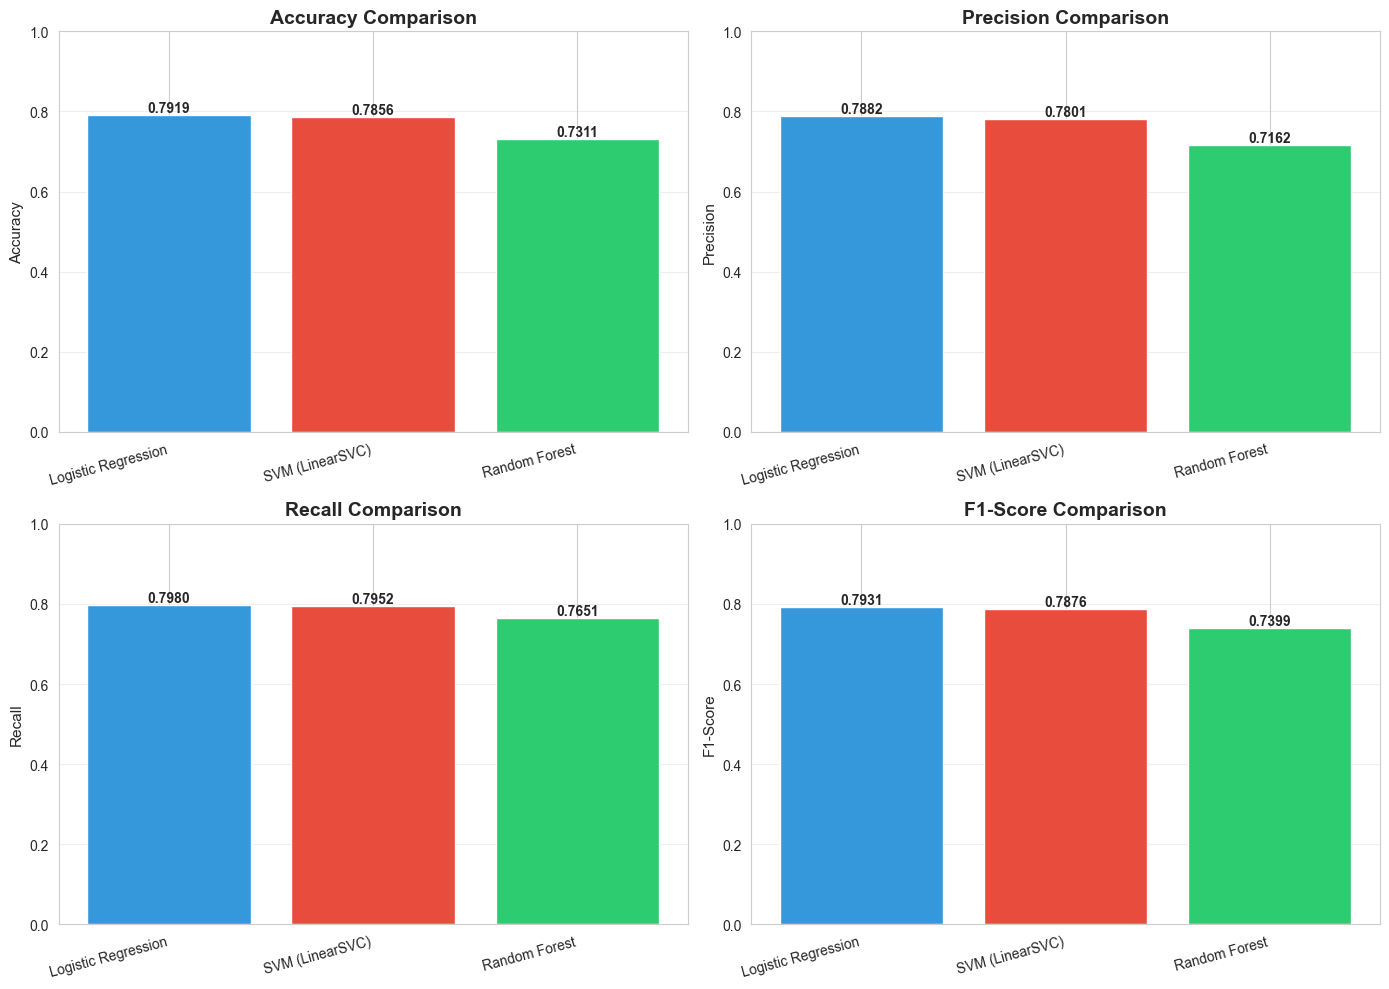

✓ Comparison chart saved


In [9]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (LinearSVC)', 'Random Forest'],
    'Accuracy': [lr_accuracy, svm_accuracy, rf_accuracy],
    'Precision': [lr_precision, svm_precision, rf_precision],
    'Recall': [lr_recall, svm_recall, rf_recall],
    'F1-Score': [lr_f1, svm_f1, rf_f1]
})

# Sort by F1-Score
results = results.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))

# Find best model
best_model_name = results.iloc[0]['Model']
best_f1 = results.iloc[0]['F1-Score']
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results['Model'], results[metric], color=colors)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(results['Model'], rotation=15, ha='right')

plt.tight_layout()
plt.savefig('../visuals/charts/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Comparison chart saved")

## 10. Confusion Matrices

**Confusion Matrix** shows:
- **True Positives (TP)**: Correctly predicted positive
- **True Negatives (TN)**: Correctly predicted negative
- **False Positives (FP)**: Predicted positive, actually negative
- **False Negatives (FN)**: Predicted negative, actually positive

Generating confusion matrices...



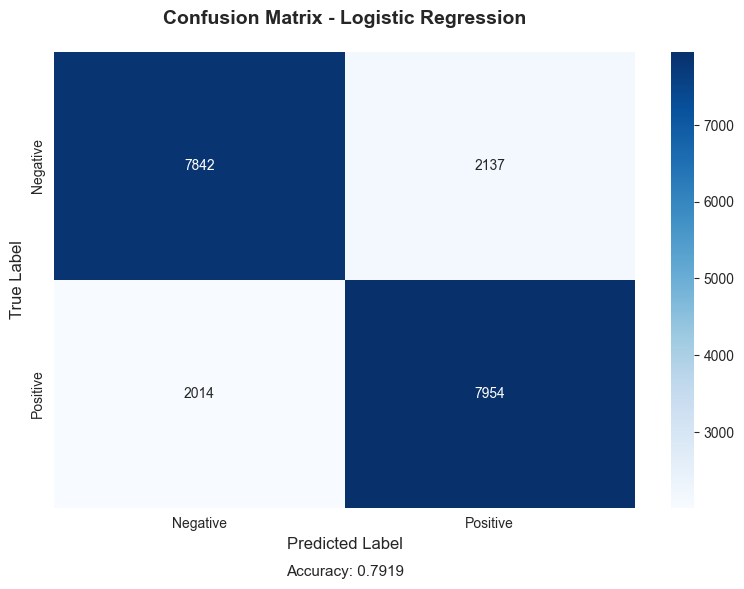

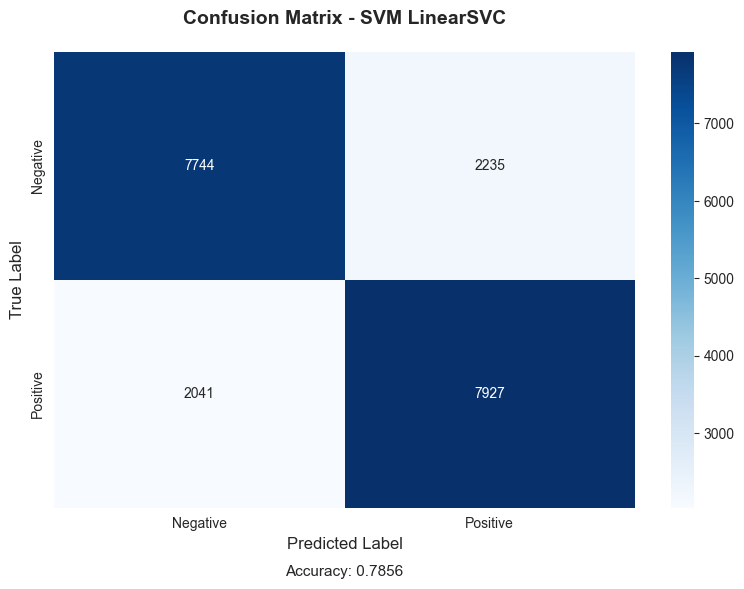

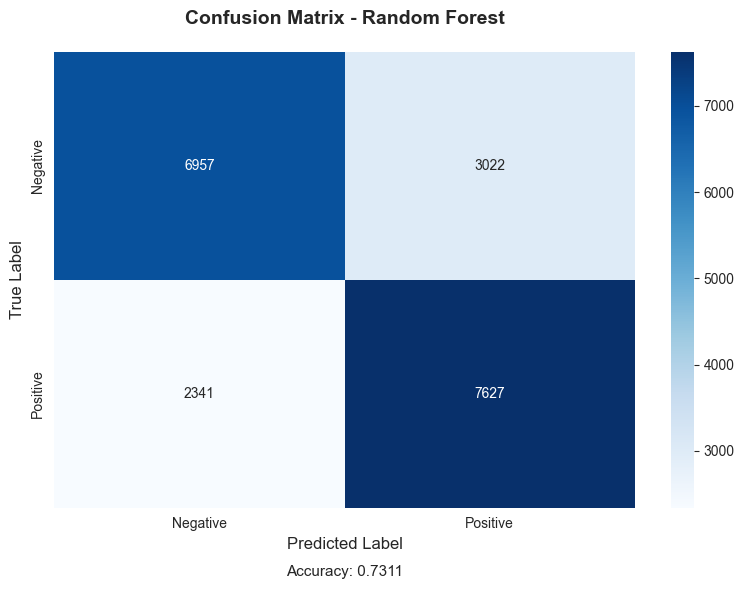

In [10]:
# Plot confusion matrices for all models
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    plt.text(0.5, -0.15, f'Accuracy: {accuracy:.4f}', 
             ha='center', transform=plt.gca().transAxes, fontsize=11)
    filename = f"../visuals/confusion_matrices/{model_name.lower().replace(' ', '_')}_cm.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    return cm

print("Generating confusion matrices...\n")
cm_lr = plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')
cm_svm = plot_confusion_matrix(y_test, y_pred_svm, 'SVM LinearSVC')
cm_rf = plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

## 11. Save Best Model

In [11]:
# Determine which model is best based on F1-Score
models_dict = {
    'Logistic Regression': (lr_model, lr_f1),
    'SVM (LinearSVC)': (svm_model, svm_f1),
    'Random Forest': (rf_model, rf_f1)
}

# Find best model
best_model_name = max(models_dict, key=lambda k: models_dict[k][1])
best_model = models_dict[best_model_name][0]
best_score = models_dict[best_model_name][1]

# Save all models
print("Saving models...\n")

for model_name, (model, score) in models_dict.items():
    filename = MODELS_PATH / f"{model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ {model_name} saved to: {filename}")

# Also save best model separately
best_model_file = MODELS_PATH / 'best_model.pkl'
with open(best_model_file, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n🏆 Best model ({best_model_name}) saved to: {best_model_file}")
print(f"   F1-Score: {best_score:.4f}")

Saving models...

✓ Logistic Regression saved to: ..\models\ml\logistic_regression.pkl
✓ SVM (LinearSVC) saved to: ..\models\ml\svm_linearsvc.pkl
✓ Random Forest saved to: ..\models\ml\random_forest.pkl

🏆 Best model (Logistic Regression) saved to: ..\models\ml\best_model.pkl
   F1-Score: 0.7931


## 12. Test on Sample Texts

In [12]:
# Test the best model on new sample texts
sample_texts = [
    "i love this product it is amazing",
    "this is the worst experience ever",
    "absolutely fantastic cant wait to use it again",
    "terrible service very disappointed",
    "great quality highly recommend",
    "waste of money do not buy"
]

print("="*60)
print("TESTING ON SAMPLE TEXTS")
print("="*60)

# Transform sample texts using TF-IDF
sample_tfidf = tfidf.transform(sample_texts)

# Make predictions
predictions = best_model.predict(sample_tfidf)

# Display results
for text, pred in zip(sample_texts, predictions):
    sentiment = "😊 POSITIVE" if pred == 1 else "😞 NEGATIVE"
    print(f"\nText: \"{text}\"")
    print(f"Prediction: {sentiment}")

print("\n" + "="*60)

TESTING ON SAMPLE TEXTS

Text: "i love this product it is amazing"
Prediction: 😊 POSITIVE

Text: "this is the worst experience ever"
Prediction: 😞 NEGATIVE

Text: "absolutely fantastic cant wait to use it again"
Prediction: 😊 POSITIVE

Text: "terrible service very disappointed"
Prediction: 😞 NEGATIVE

Text: "great quality highly recommend"
Prediction: 😊 POSITIVE

Text: "waste of money do not buy"
Prediction: 😞 NEGATIVE



## 13. Summary

### Key Findings:

**Dataset:**
- Training samples: 80,000 tweets
- Testing samples: 20,000 tweets
- Features: TF-IDF with 10,000 words

**Models Trained:**
1. Logistic Regression - Fast, simple baseline
2. SVM (LinearSVC) - Good for text classification
3. Random Forest - Ensemble method

**Next Steps (Week 4):**
- Implement Deep Learning models (RNN, LSTM, GRU)
- Compare DL vs ML performance
- Try word embeddings (Word2Vec, GloVe)

---

✓ Notebook 02 Complete!

In [13]:
# Final summary
print("="*80)
print("NOTEBOOK 02 SUMMARY")
print("="*80)
print(f"\n✓ Dataset loaded: {len(df)} tweets")
print(f"✓ Train/Test split: {len(X_train)}/{len(X_test)} samples")
print(f"✓ TF-IDF features: {X_train_tfidf.shape[1]} dimensions")
print(f"\n✓ Models trained: 3 (Logistic Regression, SVM, Random Forest)")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Best F1-Score: {best_score:.4f}")
print(f"\n✓ Models saved to: {MODELS_PATH}")
print(f"✓ Visualizations saved to: {VISUALS_PATH}")
print("\n" + "="*80)
print("Ready for Week 4: Deep Learning Models!")
print("="*80)

NOTEBOOK 02 SUMMARY

✓ Dataset loaded: 99735 tweets
✓ Train/Test split: 79788/19947 samples
✓ TF-IDF features: 10000 dimensions

✓ Models trained: 3 (Logistic Regression, SVM, Random Forest)
✓ Best model: Logistic Regression
✓ Best F1-Score: 0.7931

✓ Models saved to: ..\models\ml
✓ Visualizations saved to: ..\visuals\confusion_matrices

Ready for Week 4: Deep Learning Models!
